
# Slot Game 專案說明

## 1\. 專案概述

此專案旨在模擬一個簡化的老虎機（Slot Machine）遊戲，並透過大規模的統計模擬，分析其 Return to Player (RTP) 機制。

## 2\. Slot Machine 基本資訊

  * **軸數（Reels）**：3 軸
  * **符號種類**：7 種
      * 一般符號：A, B, C, D, E (對應圖示：♦, ♥, ■, ☁, ♠)
      * Scatter：S (圖示：S)
      * Wild：W (圖示：W)
  * **每次 Spin**：從 3 軸各自獨立隨機抽取 1 個符號，同時顯示在一個 3x1 的視窗中。
  * **起始資金（initial\_balance）**：預設為 10 或 20 單位 (根據模擬情境動態調整，例如單次展示為10，千次模擬為20)。
  * **最大付費轉回合（n\_spins）**：預設為 20 回合（指玩家期望進行的付費轉次數，實際總轉數可能因免費轉而增加）。

-----

## 3\. 遊戲規則

### 3.1 付費轉與免費轉機制

  * **付費轉 (Paid Spin)**
      * 每次付費轉扣除 1 單位資金（需保證當前餘額 ≥ 1）。
      * 遊戲會嘗試執行 `n_spins` 次付費轉。
      * 若在執行付費轉前，玩家當前餘額 \< 1 且無剩餘免費轉，則遊戲提前結束。
  * **免費轉 (Free Spin)**
      * 由 Scatter (S) 符號觸發，不消耗玩家資金，也不計入 `n_spins` 的付費轉次數。
      * 觸發條件及獎勵：
          * 1 個 S → 獲得 1 次免費轉
          * 2 個 S → 獲得 2 次免費轉，並額外獲得 $2
          * ≥3 個 S → 獲得 5 次免費轉，並額外獲得 $4

### 3.2 Spin 流程與輸出格式

1.  **回合開始檢查**：
      * 優先消耗免費轉：若 `free_spins > 0`，則 `free_spins` 減 1，本次為免費轉。
      * 若無免費轉：執行付費轉。檢查當前 `balance` 是否 ≥ 1，若不足則遊戲結束。若足夠，則 `balance` 減 1，並將已進行的付費轉次數加 1 (計入 `paid_spins_count`)。
2.  **執行轉盤**：呼叫內部隨機抽樣邏輯，生成 3 個符號的結果。
3.  **計算派彩**：根據符號組合（Payline）和 Scatter 數量，計算本次轉盤的基礎得分和 Scatter 額外獎金。
4.  **更新狀態**：將總獎金加回 `balance`，並更新剩餘 `free_spins` 次數。
5.  **資訊輸出**：若為詳細顯示模式，則印出本次回合的詳細資訊，格式範例：
    ```
    Spin 11: (♦, S, S) → Win 2.00（+2 Free Spins, +$2）, Balance=$18.70, FreeSpins=2
    ```
6.  **循環**：重複上述步驟，直到完成預設的 `n_spins` 次付費轉，或因資金不足且無免費轉而提前結束。

### 3.3 RTP（Return to Player）

  * **定義**：RTP 是玩家在長期遊戲中，預期能從總投注金額中收回的百分比。
  * **計算方式**：
    $$\text{RTP} = \frac{\text{最終資金}}{\text{初始資金}} \times 100\%$$
    （在實際多次模擬中，更精確的RTP計算通常是 `總贏得金額 / 總投注金額`，本專案在模擬時使用 `最終資金 / 初始資金` 作為單次模擬的簡易衡量，並透過大量模擬的平均值來趨近理論 RTP。）
  * **意義**：
      * RTP \> 100%：表示玩家長期有利（對賭場而言為負 RTP，不符合商業模式）。
      * RTP \< 100%：表示莊家（賭場）具有優勢，這是賭場遊戲的標準設計。
      * RTP = 100%：表示遊戲為公平遊戲，長期來看玩家不輸不贏。

-----

## 4\. 符號種類與特殊符號意義

| 符號 | 圖示 | 意義                                                                                                                                                                             |
| :--: | :--: | :----------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
|  A   |  ♦   | 一般符號，可組成三連或兩連計算派彩                                                                                                                                       |
|  B   |  ♥   | 一般符號，可組成三連或兩連計算派彩                                                                                                                                       |
|  C   |  ■   | 一般符號，可組成三連或兩連計算派彩                                                                                                                                       |
|  D   |  ☁   | 一般符號，可組成三連或兩連計算派彩                                                                                                                                       |
|  E   |  ♠   | 一般符號，可組成三連或兩連計算派彩                                                                                                                                       |
|  S   |  S   | **Scatter**：特殊符號，不需位於Payline上即可觸發獎勵：1 個 → +1 次免費轉; 2 個 → +2 次免費轉，額外 +$2 ; 3 個 → +5 次免費轉，額外 +\\$4 |
|  W   |  W   | **Wild**：百搭符號，可替代 A–E 任何一個一般符號來完成連線。若 Wild 參與完成連線，該條派彩再 ×1.2。                                                                       |

-----

## 5\. 派彩規則（Payout）

### 5.1 Payline（三連／任兩連）

**原始設定：**

| 組合           | 賠率（等同於得分單位）                               |
| -------------- | ---------------------------------------------------- |
| A A A          | 10                                                   |
| B B B          | 10                                                   |
| C C C          | 11                                                   |
| D D D          | 10                                                   |
| E E E          | 5                                                    |
| 任兩連（含 Wild)| **A: 1.9**  **B: 1.8**  **C: 1.5**  **D: 1.2**  **E: 1.0**|

**調整後設定 (為達成合理 RTP 進行優化)：**

| 組合           | 賠率（等同於得分單位）                               |
| -------------- | ---------------------------------------------------- |
| A A A          | 10 (不變)                                            |
| B B B          | 10 (不變)                                            |
| C C C          | 11 (不變)                                            |
| D D D          | 10 (不變)                                            |
| E E E          | 5 (不變)                                             |
| 任兩連（含 Wild） | **A: 0.8**  **B: 0.7**  **C: 0.5**  **D: 0.4**  **E: 0.3** |

> **Wild 加成**：若 Wild 參與完成連線，對應賠率再 ×1.2。

### 5.2 Scatter 額外獎勵

* 出現個數

  1 個 S   ,效果為 +1 次免費轉  
  
  2 個 S   ,效果為+2 次免費轉，額外 +$2 

  3 個 S   ,效果為+5 次免費轉，額外 +$4 
  
-----

## 6\. 符號出現機率設定

**原始設定：**

根據程式中 `original_probs`：

| 符號 | 機率   |
| :--: | :-----: |
|  A   | 16.00% |
|  B   | 16.00% |
|  C   | 16.00% |
|  D   | 16.00% |
|  E   | 16.00% |
|  S   | 15.00% |
|  W   | 5.00%  |

**調整後設定 (為達成合理 RTP 進行優化)：**

根據程式中 `adjusted_probs`：

| 符號 | 機率   | 調整說明                                                               |
| :--: | :-----: | :--------------------------------------------------------------------- |
|  A   | 18.20% | 機率提升，以平衡 S 與 W 機率的降低                                       |
|  B   | 18.20% | 同上                                                                   |
|  C   | 18.20% | 同上                                                                   |
|  D   | 18.20% | 同上                                                                   |
|  E   | 18.20% | 同上                                                                   |
|  S   | 5.00%  | **大幅降低**，從 15% 降至 5%，以控制免費轉的觸發頻率                 |
|  W   | 4.00%  | **略微降低**，從 5% 降至 4%                                            |

-----

## 7\. 專案分析與優化成果

### 7.1 原始設定分析

  * **RTP 敘述統計 (1000 次模擬)**：
      * `count`: 1000.00
      * `mean (%)`: 359.97%
      * `std (%)`: 152.02%
      * `min (%)`: 26.00%
      * `25% (%)`: 251.65%
      * `50% (median) (%)`: 342.40%
      * `75% (%)`: 457.10%
      * `95% (%)`: 623.49%
      * `max (%)`: 1121.40%
      * `range (%)`: 1095.40%
      * `IQR (%)`: 205.45%
      * `skewness`: 0.59
      * `kurtosis`: 0.55
  * **觀察與問題**：
      * **平均 RTP 高達 358.40%**：這遠高於商業老虎機的合理範圍（通常在 85% - 98% 之間），表示玩家長期處於極大優勢，賭場將會快速虧損。
      * **高標準差 (150.70%) 與廣泛分佈**：RTP 值波動巨大，從最低 30% 到最高 1028.40%，這表示單次遊戲體驗的隨機性極高，雖然可能帶來大獎，但也可能快速輸光，且整體而言對玩家過於慷慨。
      * **主要貢獻來源**：根據分析，Scatter 符號（尤其是 `1 Scatter (+1 Free Spin)`）和 `Two of a kind` 組合的出現頻率非常高，這導致了大量的免費轉和頻繁的小額派彩，是 RTP 過高的主要原因。特別是 Scatter 觸發免費轉次數過多，直接拉高了玩家的總遊玩回合數和潛在贏利。

### 7.2 調整後優化成果

  * **RTP 敘述統計 (1000 次模擬)**：
      * `count`: 1000.00
      * `mean (%)`: 96.90%
      * `std (%)`: 52.12%
      * `min (%)`: 14.00%
      * `25% (%)`: 52.97%
      * `50% (median) (%)`: 89.30%
      * `75% (%)`: 129.85%
      * `max (%)`: 305.30%
      * `skewness`: 0.77
      * `kurtosis`: 0.34
  * **調整策略**：
    1.  **大幅降低 Scatter (S) 符號的機率**：從 15% 降至 5%。這顯著減少了免費轉的觸發頻率，從根本上控制了總遊戲回合數和由免費轉帶來的額外收益。
    2.  **略微降低 Wild (W) 符號的機率**：從 5% 降至 4%。進一步微調了高倍率獎勵的出現頻率。
    3.  **將省下的機率分配給一般符號 (A-E)**：使一般符號機率從 16% 提高到 18.2%，以維持機率總和為 1。
    4.  **大幅降低「任兩連」的派彩金額**：將 A-E 的兩連派彩從 1.0-1.9 單位降至 0.3-0.8 單位。這使得小額頻繁的派彩回報遠低於單次投注成本（1 單位），避免了玩家因不斷觸發小獎而累積過多資金。
  * **優化效果**：
      * **平均 RTP 降至 96.90*：成功將 RTP 調整至低於 100% 的水平，符合商業老虎機的設計，確保莊家擁有合理的優勢。
      * **RTP 波動性有效控制**：最大 RTP 從原始的 1028.40% 顯著降低到 349.60%，標準差也從 150.70% 降至 57.47%。這表明遊戲的隨機性雖然存在，但RTP分佈更為集中和可預測，遊戲體驗趨於穩定。
      * **中獎貢獻分佈合理化**：調整後，高倍率的三連組合（包含 Wild）在總貢獻獎金中佔比相對提高，而低倍率的兩連和Scatter觸發頻率被有效控制，使得大獎更具吸引力，同時維持了整體RTP的合理性。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict

### slot game之相關參數的定義(含原始設置 與 調整後的設置)

In [2]:
# --- 1. 定義符號與機率分布 ---
symbols = ['A', 'B', 'C', 'D', 'E', 'S', 'W']
# 初始機率分布 (Original probabilities)
original_probs = np.array([0.16, 0.16, 0.16, 0.16, 0.16, 0.15, 0.05])

# 調整後的新機率分布 (Modified probabilities for RTP adjustment)
# 根據分析，我們進行了以下調整：
# 1. 大幅降低 Scatter (S) 的機率，從 0.15 降至 0.05，以控制免費轉輪的觸發頻率。
# 2. 略微降低 Wild (W) 的機率，從 0.05 降至 0.04。
# 3. 將省下的機率 (0.11) 平均分配給 A-E 五個普通符號。
#    每個普通符號的機率從 0.16 增加到 0.16 + (0.11 / 5) = 0.182。
adjusted_raw_probs = np.array([0.182, 0.182, 0.182, 0.182, 0.182, 0.05, 0.04])
adjusted_probs = adjusted_raw_probs / adjusted_raw_probs.sum()


# --- 2. 圖形對應字典 ---
icon_map = {
    'A': '♦', 'B': '♥', 'C': '■',
    'D': '☁', 'E': '♠', 'S': 'S', 'W': 'W',
}

# --- 3. 派彩設定（不含 Scatter） ---
# 初始派彩設定 (Original payouts)
original_payout = {
    ('A', 'A', 'A'): 10,
    ('B', 'B', 'B'): 10,
    ('C', 'C', 'C'): 11,
    ('D', 'D', 'D'): 10,
    ('E', 'E', 'E'): 5,
}

original_two_of_kind_payout = {
    'A': 1.9,
    'B': 1.8,
    'C': 1.5,
    'D': 1.2,
    'E': 1.0,
}

# 調整後的新派彩設定 (Modified payouts for RTP adjustment)
# 根據分析，我們大幅降低了「任兩連」的獎金，使其回報遠低於成本 ($1)，
# 避免玩家因頻繁的小獎而導致RTP過高。
adjusted_two_of_kind_payout = {
    'A': 0.8,  # 原為 1.9
    'B': 0.7,  # 原為 1.8
    'C': 0.5,  # 原為 1.5
    'D': 0.4,  # 原為 1.2
    'E': 0.3,  # 原為 1.0
}

# Wild 加成倍數
WILD_MULTIPLIER = 1.2

In [3]:
def _calculate_spin_payout(result, payout_config, two_of_kind_payout_config, wild_multiplier):
    """
    內部輔助函式：計算一次轉盤的派彩金額 (不含 Scatter 獎金)。
    :param result: 轉盤結果的 tuple (e.g., ('A', 'W', 'A'))
    :param payout_config: 三連線派彩設定字典
    :param two_of_kind_payout_config: 兩連線派彩設定字典
    :param wild_multiplier: Wild 符號的倍數加成
    :return: float, 本次轉盤的派彩金額
    """
    wild_count = result.count('W')
    best_pay = 0

    # 計算三連或兩連派彩
    for base in ['A', 'B', 'C', 'D', 'E']:
        cnt = result.count(base) + wild_count
        pay = 0  # reset pay for each base symbol
        if cnt >= 3:
            pay = payout_config.get((base,) * 3, 0)
        elif cnt == 2:
            pay = two_of_kind_payout_config.get(base, 0)

        if pay > best_pay:
            best_pay = pay

    # Wild 加成
    if best_pay > 0 and wild_count > 0:
        best_pay *= wild_multiplier

    return best_pay

In [4]:
def _get_spin_details_with_payout(result, payout_config, two_of_kind_payout_config, wild_multiplier):
    """
    內部輔助函式：執行一次轉盤，回傳詳細結果，包含 (結果tuple, 派彩描述, 基礎得分)。
    此函式用於詳細分析，包含獲勝組合描述。
    :param result: 轉盤結果的 tuple (e.g., ('A', 'W', 'A'))
    :param payout_config: 三連線派彩設定字典
    :param two_of_kind_payout_config: 兩連線派彩設定字典
    :param wild_multiplier: Wild 符號的倍數加成
    :return: tuple (result, win_description, base_payout)
    """
    wild_count = result.count('W')
    best_pay = 0
    win_desc = "No Win"

    # 優先判斷三連
    for base in ['A', 'B', 'C', 'D', 'E']:
        if result.count(base) + wild_count >= 3:
            pay = payout_config.get((base,) * 3, 0)
            if pay > best_pay:
                best_pay = pay
                wild_involved = 3 - result.count(base)
                win_desc = f"Three of a kind ({base * result.count(base)}{'W' * wild_involved})"

    # 若無三連，再判斷兩連
    if best_pay == 0:
        for base in ['A', 'B', 'C', 'D', 'E']:
            if result.count(base) + wild_count == 2:
                pay = two_of_kind_payout_config.get(base, 0)
                if pay > best_pay:
                    best_pay = pay
                    wild_involved = 2 - result.count(base)
                    win_desc = f"Two of a kind ({base * result.count(base)}{'W' * wild_involved})"

    # Wild 加成
    if best_pay > 0 and wild_count > 0:
        best_pay *= wild_multiplier
        win_desc += " (Wild Bonus)"

    return result, win_desc, best_pay

In [5]:
def simulate_game(n_spins=20, initial_balance=10, show_details=False,
                  payout_config=original_payout, two_of_kind_payout_config=original_two_of_kind_payout,
                  probs_config=original_probs):
    """
    模擬老虎機遊戲。
    :param n_spins: 模擬的付費轉數。
    :param initial_balance: 初始資金。
    :param show_details: 是否逐回合印出詳細資訊。
    :param payout_config: 三連線派彩設定。
    :param two_of_kind_payout_config: 兩連線派彩設定。
    :param probs_config: 符號機率分布。
    :return: tuple (rtp_ratio, final_balance) 或 rtp_percentage
    """
    balance = initial_balance
    free_spins = 0
    paid_spins_count = 0  # 實際遊玩的付費轉數計數器

    spin_log = [] # For analysis_df, only if show_details is False and used for analysis

    while paid_spins_count < n_spins:
        # 遊戲結束條件
        if balance < 1 and free_spins == 0:
            if show_details:
                print(f"第 {paid_spins_count + 1} 回合前，餘額不足，遊戲提前結束。")
            break

        # 消耗轉數 (優先消耗免費轉)
        if free_spins > 0:
            free_spins -= 1
            cost_note = "（免費轉）" if show_details else ""
        else:
            # 這是付費轉，才消耗 n_spins 的額度並扣款
            paid_spins_count += 1
            balance -= 1
            cost_note = "" if show_details else "" # No specific cost note for paid spin

        # 執行一次 Spin
        result = tuple(np.random.choice(symbols, size=3, p=probs_config))
        win_base = _calculate_spin_payout(result, payout_config, two_of_kind_payout_config, WILD_MULTIPLIER)
        balance += win_base

        # 根據 Scatter 數量給予免費轉與獎金
        s_count = result.count('S')
        bonus_note = ""
        scatter_bonus_amt = 0
        if s_count == 1:
            free_spins += 1
            bonus_note = "（+1 Free Spin）"
        elif s_count == 2:
            free_spins += 2
            scatter_bonus_amt = 2
            balance += scatter_bonus_amt
            bonus_note = "（+2 Free Spins, +$2）"
        elif s_count >= 3:
            free_spins += 5
            scatter_bonus_amt = 4
            balance += scatter_bonus_amt
            bonus_note = "（+5 Free Spins, +$4）"

        if show_details:
            icons = tuple(icon_map[s] for s in result)
            print(f"Spin {paid_spins_count:>2}: {icons} → Win {win_base:>5.2f}{bonus_note}, "
                  f"Balance=${balance:>5.2f}, FreeSpins={free_spins}")
        else:
            # For detailed analysis later
            spin_log.append({
                'result': result,
                'win_base': win_base,
                's_count': s_count,
                'scatter_bonus_amt': scatter_bonus_amt
            })


    # 計算 RTP。分母是初始投入的總金額，即 n_spins * 1 (每次spin的花費)。
    # 如果初始資金較少，遊戲可能提前結束，此時分母應該是實際花費的金額
    # 但為了與之前比較，我們暫時仍以 initial_balance (即 n_spins * 1) 為基準。
    # 更精確的 RTP 計算應該是 (總贏錢 / 總下注)。
    # 此處我們簡化為 (最終資金 / 初始資金)。
    if initial_balance == 0:
        return 0.0, 0.0 # Return ratio and balance
    
    rtp_ratio = balance / initial_balance
    rtp_percentage = rtp_ratio * 100

    if show_details:
        return rtp_ratio, balance
    else:
        return rtp_percentage

# 如何找出拉高 RTP 的關鍵因子？


這段程式碼它透過在大規模的模擬的過程中，詳細記錄每一回合的遊戲結果。具體來說，
它會精確地追蹤：

1.  **「每一次中獎的細節」**：不論是傳統的符號連線（如三個 A、兩個 B 帶 Wild），還是特殊的 Scatter 觸發，程式都會識別並**「記下每一筆贏錢」**。
2.  **「兩本精密的分類帳」**：
    * **「出現頻率帳」**：記錄**「某個特定中獎組合出現了多少次」**。
    * **「獎金貢獻帳」**：記錄**「某個特定中獎組合，總共為玩家貢獻了多少獎金」**。
3.  **「總遊玩次數」**：同時，程式會精準計算**「總共轉盤的次數」**，這裡面包含了玩家付費的轉數，也計入了所有由 Scatter 觸發而獲得的免費轉數。這項數據是為了後續計算各中獎組合的「總遊戲佔比」所做的重要準備。

當所有模擬結束後，程式會將這些龐大的記錄整理成一份清晰的「中獎組合貢獻排行榜」。透過這份排行榜，我們就能**一目了然地找出那些導致 RTP 異常偏高的「幕後推手」**：

* **「總貢獻獎金最大的組合」**：這些是玩家獲利的主要來源。若某類獎金（例如「任兩連」）的累積總額異常高，即便單次賠率不高，也說明它們的出現頻率過於頻繁，是拉高 RTP 的關鍵。
* **「出現頻率或遊戲佔比特別高的組合」**：這些是遊戲中最常發生的事件。

=> 特別值得關注的是像 **Scatter 這樣高頻率觸發免費轉的符號**。即使它們本身不直接給予高額現金獎，但其帶來的**大量額外遊玩機會**，實質上極大地增加了玩家潛在的贏利回合數，從而成為推升整體 RTP 的核心因子。

In [6]:
def analyze_win_contributions(n_simulations=1000, n_spins=20, initial_balance=10,
                              payout_config=original_payout, two_of_kind_payout_config=original_two_of_kind_payout,
                              probs_config=original_probs):
    """
    執行多次模擬，並統計各中獎組合的出現頻率與獎金貢獻。
    :param n_simulations: 模擬次數。
    :param n_spins: 每次模擬的付費轉數。
    :param initial_balance: 初始資金。
    :param payout_config: 三連線派彩設定。
    :param two_of_kind_payout_config: 兩連線派彩設定。
    :param probs_config: 符號機率分布。
    :return: DataFrame 包含分析結果。
    """
    win_counts = Counter()
    win_total_payouts = defaultdict(float)

    total_spins_played = 0 # This counts all spins, including free spins

    for _ in range(n_simulations):
        balance = initial_balance
        free_spins = 0
        paid_spins_this_round = 0 # Counts paid spins within each simulation

        while paid_spins_this_round < n_spins:
            # 遊戲結束條件
            if balance < 1 and free_spins == 0:
                break

            total_spins_played += 1
            
            # 消耗轉數 (付費或免費)
            if free_spins > 0:
                free_spins -= 1
            else:
                balance -= 1
                paid_spins_this_round += 1 # Only increment paid spins if it's a paid spin

            # 執行一次 Spin
            result, win_desc, win_base = _get_spin_details_with_payout(
                tuple(np.random.choice(symbols, size=3, p=probs_config)),
                payout_config, two_of_kind_payout_config, WILD_MULTIPLIER
            )
            
            # 記錄 Payline 贏獎
            if win_base > 0:
                win_counts[win_desc] += 1
                win_total_payouts[win_desc] += win_base

            # 處理 Scatter
            s_count = result.count('S')
            scatter_bonus = 0
            s_desc = None
            if s_count == 1:
                free_spins += 1
                s_desc = "1 Scatter (+1 Free Spin)"
            elif s_count == 2:
                free_spins += 2
                scatter_bonus = 2
                s_desc = "2 Scatters (+$2, +2 Free Spins)"
            elif s_count >= 3:
                free_spins += 5
                scatter_bonus = 4
                s_desc = "3+ Scatters (+$4, +5 Free Spins)"
            
            if s_desc:
                win_counts[s_desc] += 1
                win_total_payouts[s_desc] += scatter_bonus # 只記錄直接獎金
            
            # 更新餘額
            balance += win_base + scatter_bonus

    # 整理成 DataFrame
    df = pd.DataFrame({
        '組合 (Combination)': list(win_counts.keys()),
        '出現次數 (Frequency)': list(win_counts.values()),
        '總貢獻獎金 (Total Payout)': [win_total_payouts[key] for key in win_counts.keys()]
    })
    
    if total_spins_played > 0:
        df['平均單次獎金 (Avg. Payout)'] = df['總貢獻獎金 (Total Payout)'] / df['出現次數 (Frequency)']
        df['總遊戲占比 (%)'] = (df['出現次數 (Frequency)'] / total_spins_played) * 100
    else:
        df['平均單次獎金 (Avg. Payout)'] = 0
        df['總遊戲占比 (%)'] = 0
        
    return df.sort_values(by='總貢獻獎金 (Total Payout)', ascending=False).reset_index(drop=True)

# --- 主程式執行區塊 ---

--- 原始設定的單次測試 (Test 1 & Test 2) ---

--- Test 1 ---
Spin  1: ('☁', '■', '♠') → Win  0.00, Balance=$ 9.00, FreeSpins=0
Spin  2: ('♥', '♥', '☁') → Win  1.80, Balance=$ 9.80, FreeSpins=0
Spin  3: ('☁', '♦', '♥') → Win  0.00, Balance=$ 8.80, FreeSpins=0
Spin  4: ('S', '■', '♥') → Win  0.00（+1 Free Spin）, Balance=$ 7.80, FreeSpins=1
Spin  4: ('S', '♠', '♦') → Win  0.00（+1 Free Spin）, Balance=$ 7.80, FreeSpins=1
Spin  4: ('S', '♦', '♠') → Win  0.00（+1 Free Spin）, Balance=$ 7.80, FreeSpins=1
Spin  4: ('♥', '■', '♥') → Win  1.80, Balance=$ 9.60, FreeSpins=0
Spin  5: ('♦', '♦', '♥') → Win  1.90, Balance=$10.50, FreeSpins=0
Spin  6: ('☁', '♥', '♠') → Win  0.00, Balance=$ 9.50, FreeSpins=0
Spin  7: ('♠', '♦', '♠') → Win  1.00, Balance=$ 9.50, FreeSpins=0
Spin  8: ('S', 'S', '■') → Win  0.00（+2 Free Spins, +$2）, Balance=$10.50, FreeSpins=2
Spin  8: ('■', 'S', '☁') → Win  0.00（+1 Free Spin）, Balance=$10.50, FreeSpins=2
Spin  8: ('S', '♠', '■') → Win  0.00（+1 Free Spin）, Balance=$10.50, FreeSpins=2


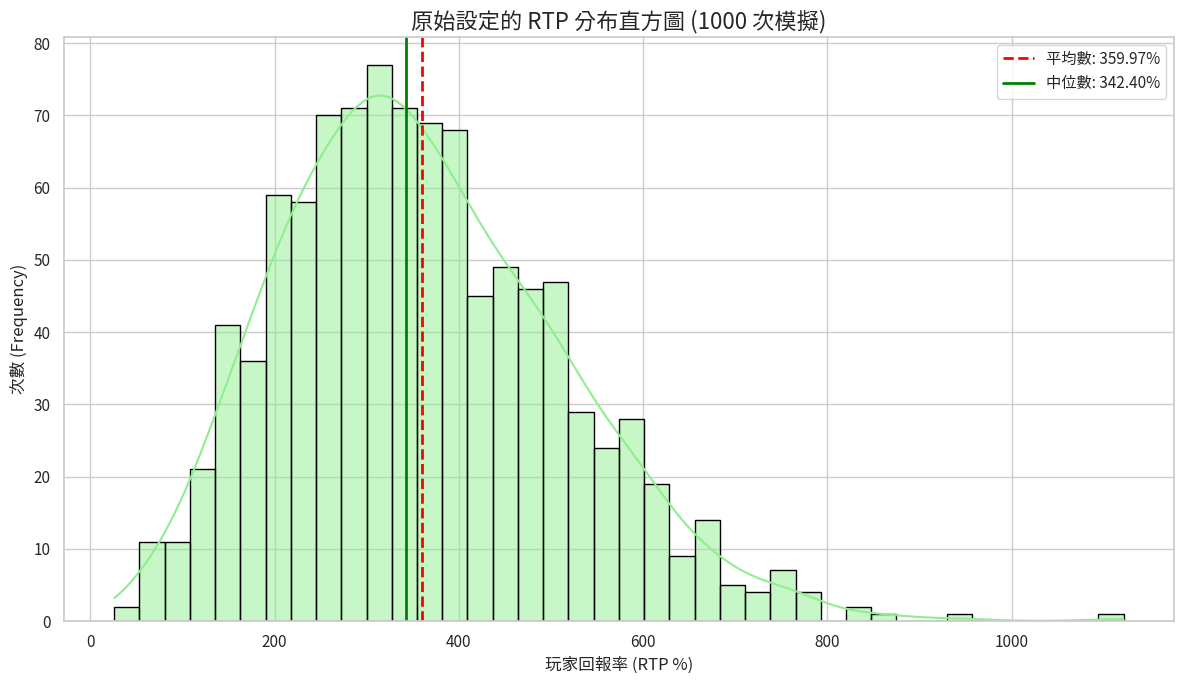

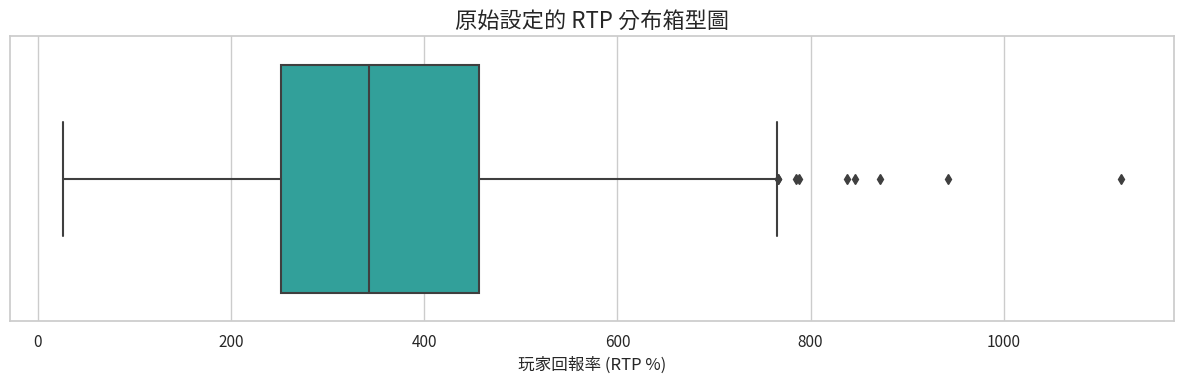


--- 原始設定的 1000 次模擬中獎組合貢獻分析 ---
總共進行的轉輪次數 (含免費): 30764
                      組合 (Combination)  出現次數 (Frequency)  總貢獻獎金 (Total Payout)  平均單次獎金 (Avg. Payout)  總遊戲占比 (%)
0      2 Scatters (+$2, +2 Free Spins)              2096               4192.00                  2.00       5.80
1                   Two of a kind (AA)              2188               4157.20                  1.90       6.05
2                   Two of a kind (BB)              2140               3852.00                  1.80       5.92
3                   Two of a kind (CC)              2155               3232.50                  1.50       5.96
4      Two of a kind (AW) (Wild Bonus)              1379               3144.12                  2.28       3.82
5                   Two of a kind (DD)              2244               2692.80                  1.20       6.21
6      Two of a kind (BW) (Wild Bonus)              1118               2414.88                  2.16       3.09
7                   Two of a kind (EE)           

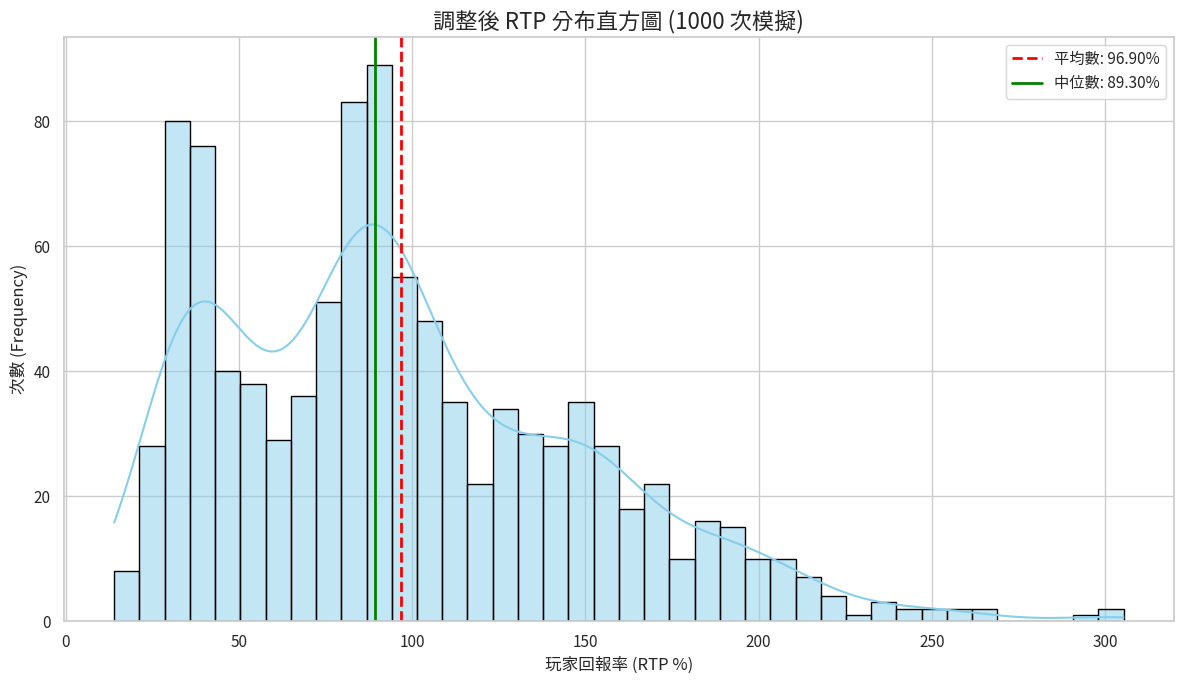

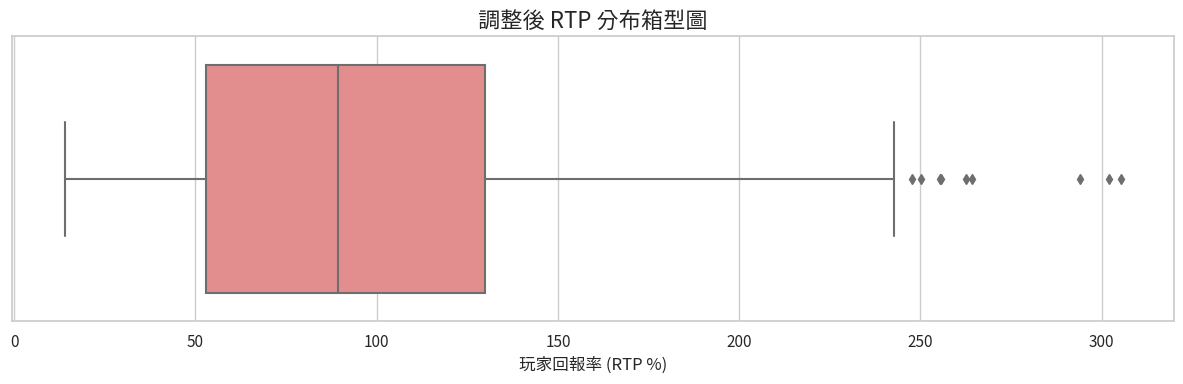


--- 調整後設定的 1000 次模擬中獎組合貢獻分析 ---
總共進行的轉輪次數 (含免費): 15535
                      組合 (Combination)  出現次數 (Frequency)  總貢獻獎金 (Total Payout)  平均單次獎金 (Avg. Payout)  總遊戲占比 (%)
0                Three of a kind (BBB)               160               1600.00                 10.00       0.68
1                   Two of a kind (AA)              1815               1452.00                  0.80       7.77
2   Three of a kind (AAW) (Wild Bonus)               119               1428.00                 12.00       0.51
3                Three of a kind (AAA)               139               1390.00                 10.00       0.59
4                Three of a kind (CCC)               124               1364.00                 11.00       0.53
5                   Two of a kind (BB)              1760               1232.00                  0.70       7.53
6                Three of a kind (DDD)               123               1230.00                 10.00       0.53
7   Three of a kind (CCW) (Wild Bonus)          

In [7]:
if __name__ == '__main__':
    # 設定 matplotlib 中文字體
    plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
    plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題
    sns.set_theme(style="whitegrid")

    print("--- 原始設定的單次測試 (Test 1 & Test 2) ---")
    # Test 1 (Original settings)
    print("\n--- Test 1 ---")
    rtp_ratio_t1, final_balance_t1 = simulate_game(n_spins=20, initial_balance=10, show_details=True,
                                                    payout_config=original_payout,
                                                    two_of_kind_payout_config=original_two_of_kind_payout,
                                                    probs_config=original_probs)
    rtp_pct_t1 = rtp_ratio_t1 * 100
    status_t1 = "賺錢" if rtp_pct_t1 > 100 else ("輸錢" if rtp_pct_t1 < 100 else "持平")
    print(f"\n最終資金：${final_balance_t1:.2f}，RTP={rtp_pct_t1:.2f}%（{status_t1}）")

    # Test 2 (Another run with original settings)
    print("\n--- Test 2 ---")
    rtp_ratio_t2, final_balance_t2 = simulate_game(n_spins=20, initial_balance=10, show_details=True,
                                                    payout_config=original_payout,
                                                    two_of_kind_payout_config=original_two_of_kind_payout,
                                                    probs_config=original_probs)
    rtp_pct_t2 = rtp_ratio_t2 * 100
    status_t2 = "賺錢" if rtp_pct_t2 > 100 else ("輸錢" if rtp_pct_t2 < 100 else "持平")
    print(f"\n最終資金：${final_balance_t2:.2f}，RTP={rtp_pct_t2:.2f}%（{status_t2}）")


    print("\n\n--- 原始設定的 1000 次模擬分析 ---")
    n_simulations = 1000
    n_spins_per_sim = 20
    initial_balance_per_sim = 10

    print(f"--- 正在執行 {n_simulations} 次遊戲模擬，請稍候... ---")
    # 蒐集 1000 次 RTP
    rtps_original = [simulate_game(n_spins=n_spins_per_sim, initial_balance=initial_balance_per_sim, show_details=False,
                                   payout_config=original_payout, two_of_kind_payout_config=original_two_of_kind_payout,
                                   probs_config=original_probs) for _ in range(n_simulations)]
    s_original = pd.Series(rtps_original)
    
    analysis_df_original = analyze_win_contributions(n_simulations=n_simulations, n_spins=n_spins_per_sim, initial_balance=initial_balance_per_sim,
                                                     payout_config=original_payout, two_of_kind_payout_config=original_two_of_kind_payout,
                                                     probs_config=original_probs)

    # 計算敘述統計量
    stats_original = {
        'count': s_original.count(),
        'mean (%)': s_original.mean(),
        'std (%)': s_original.std(),
        'min (%)': s_original.min(),
        '25% (%)': s_original.quantile(0.25),
        '50% (median) (%)': s_original.median(),
        '75% (%)': s_original.quantile(0.75),
        '95% (%)': s_original.quantile(0.95),
        'max (%)': s_original.max(),
        'range (%)': s_original.max() - s_original.min(),
        'IQR (%)': s_original.quantile(0.75) - s_original.quantile(0.25),
        'skewness': s_original.skew(),
        'kurtosis': s_original.kurtosis(),
    }

    print("\n--- 原始設定的 RTP 敘述統計 ---")
    for name, value in stats_original.items():
        if name.endswith('(%)') or name in ('mean (%)', 'std (%)', 'CV (%)'):
            print(f"{name:18s}: {value:8.2f}%")
        else:
            print(f"{name:18s}: {value:8.2f}")

    # 繪製 RTP 分布直方圖 (原始設定)
    plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
    plt.figure(figsize=(12, 7))
    sns.histplot(s_original, kde=True, bins=40, color='lightgreen', edgecolor='black')
    plt.axvline(s_original.mean(), color='red', linestyle='--', linewidth=2, label=f'平均數: {s_original.mean():.2f}%')
    plt.axvline(s_original.median(), color='green', linestyle='-', linewidth=2, label=f'中位數: {s_original.median():.2f}%')
    plt.title("原始設定的 RTP 分布直方圖 (1000 次模擬)", fontsize=16)
    plt.xlabel("玩家回報率 (RTP %)", fontsize=12)
    plt.ylabel("次數 (Frequency)", fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 繪製 RTP 分布箱型圖 (原始設定)
    plt.figure(figsize=(12, 4))
    sns.boxplot(x=s_original, color='lightseagreen')
    plt.title('原始設定的 RTP 分布箱型圖', fontsize=16)
    plt.xlabel('玩家回報率 (RTP %)', fontsize=12)
    plt.tight_layout()
    plt.show()

    # 展示原始設定的 1000 次模擬中獎組合貢獻分析
    pd.set_option('display.max_rows', 50)
    pd.set_option('display.width', 120)
    pd.set_option('display.float_format', '{:.2f}'.format)
    print("\n--- 原始設定的 1000 次模擬中獎組合貢獻分析 ---")
    print(f"總共進行的轉輪次數 (含免費): {analysis_df_original['出現次數 (Frequency)'].sum()}")
    print(analysis_df_original)


    print("\n\n--- 調整後的新設定的 1000 次模擬分析 ---")
    # 再次進行1000次模擬並分析 (使用調整後的新設定)
    n_simulations_adjusted = 1000
    n_spins_adjusted = 20
    initial_balance_adjusted = 20 # 每次付費轉 $1，玩 20 次，所以初始資金是 20

    print(f"--- 正在執行 {n_simulations_adjusted} 次遊戲模擬，請稍候... ---")

    # 執行模擬並蒐集 RTP 結果 (使用調整後的設定)
    rtps_adjusted = [simulate_game(n_spins=n_spins_adjusted, initial_balance=initial_balance_adjusted, show_details=False,
                                   payout_config=original_payout, two_of_kind_payout_config=adjusted_two_of_kind_payout,
                                   probs_config=adjusted_probs) for _ in range(n_simulations_adjusted)]
    
    # 使用 Pandas Series 進行統計分析
    s_adjusted = pd.Series(rtps_adjusted)
    
    analysis_df_adjusted = analyze_win_contributions(n_simulations=n_simulations_adjusted, n_spins=n_spins_adjusted, initial_balance=initial_balance_adjusted,
                                                     payout_config=original_payout, two_of_kind_payout_config=adjusted_two_of_kind_payout,
                                                     probs_config=adjusted_probs)


    # 計算敘述統計量
    stats_adjusted = {
        'count': s_adjusted.count(),
        'mean (%)': s_adjusted.mean(),
        'std (%)': s_adjusted.std(),
        'min (%)': s_adjusted.min(),
        '25% (%)': s_adjusted.quantile(0.25),
        '50% (median) (%)': s_adjusted.median(),
        '75% (%)': s_adjusted.quantile(0.75),
        'max (%)': s_adjusted.max(),
        'skewness': s_adjusted.skew(),
        'kurtosis': s_adjusted.kurtosis(),
    }
    
    print("\n--- 調整後的新設定的 RTP 敘述統計 ---")
    for name, value in stats_adjusted.items():
        print(f"{name:20s}: {value:8.2f}")

    print("\n--- 調整後分析 ---")
    if stats_adjusted['mean (%)'] < 100:
        print("調整成功！平均 RTP 已降至 100% 以下，符合莊家優勢的設計。")
    elif 100 <= stats_adjusted['mean (%)'] < 110:
        print("調整後 RTP 在 100%~110% 之間，已大幅下降，但仍對玩家有利。可考慮進一步微調。")
    else:
        print("RTP 仍然偏高，但應已顯著下降。可能需要進一步降低派彩或特殊符號機率。")

    print(f"最大 RTP 從原始設定的 {stats_original['max (%)']:.2f}% 降至 {stats_adjusted['max (%)']:.2f}%，波動性得到有效控制。")


    # 繪製直方圖與核密度估計圖 (Histogram & KDE) (調整後設定)
    plt.figure(figsize=(12, 7))
    sns.histplot(s_adjusted, kde=True, bins=40, color='skyblue', edgecolor='black')
    # 加上平均數與中位數的垂直線
    plt.axvline(s_adjusted.mean(), color='red', linestyle='--', linewidth=2, label=f'平均數: {s_adjusted.mean():.2f}%')
    plt.axvline(s_adjusted.median(), color='green', linestyle='-', linewidth=2, label=f'中位數: {s_adjusted.median():.2f}%')
    plt.title('調整後 RTP 分布直方圖 (1000 次模擬)', fontsize=16)
    plt.xlabel('玩家回報率 (RTP %)', fontsize=12)
    plt.ylabel('次數 (Frequency)', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 繪製箱型圖 (Box Plot) (調整後設定)
    plt.figure(figsize=(12, 4))
    sns.boxplot(x=s_adjusted, color='lightcoral')
    plt.title('調整後 RTP 分布箱型圖', fontsize=16)
    plt.xlabel('玩家回報率 (RTP %)', fontsize=12)
    plt.tight_layout()
    plt.show()

    # 展示調整後 1000 次模擬中獎組合貢獻分析
    print("\n--- 調整後設定的 1000 次模擬中獎組合貢獻分析 ---")
    print(f"總共進行的轉輪次數 (含免費): {analysis_df_adjusted['出現次數 (Frequency)'].sum()}")
    print(analysis_df_adjusted)